### Preparation

https://pytorch.org/vision/main/auto_examples/others/plot_visualization_utils.html#instance-seg-output

In [1]:
from torchvision.io.image import read_image
from torchvision.transforms import v2
from torchvision.utils import make_grid
img = read_image("../data/images/0je5b4V4MQ0_1.jpg")
img2 = read_image("../data/images/7Dy2eue2_3I_1.jpg")
lst = [v2.Resize(size=(640,640))(orig_img) for orig_img in [img, img2]]
grid = make_grid(lst)

/home/alexander/Documents/Programming/ObjectDetection/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


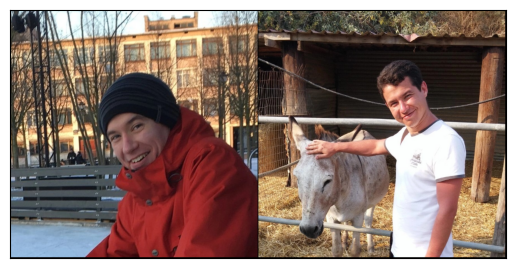

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(grid)

### Bounding boxes

/home/alexander/Documents/Programming/ObjectDetection/.venv/lib/python3.10/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


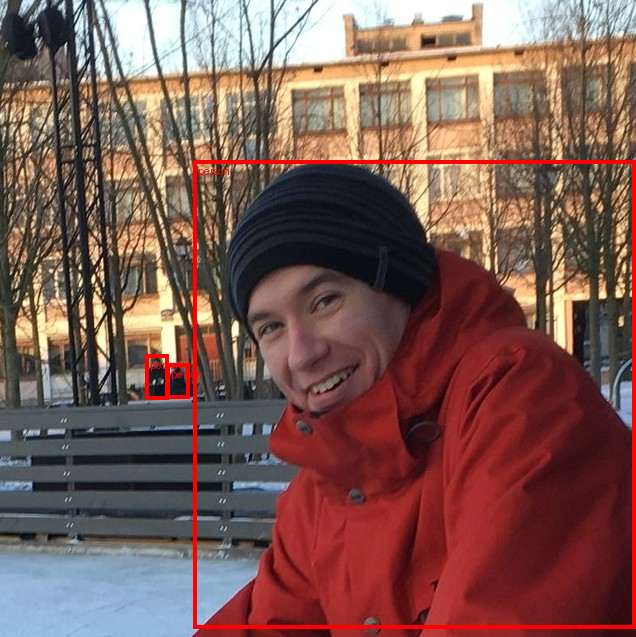

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im

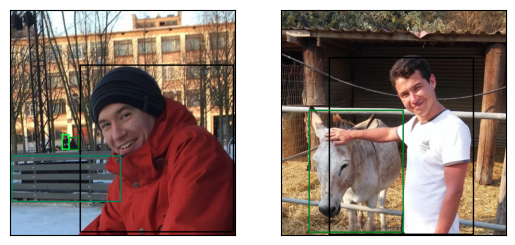

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in lst]

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

outputs = model(images)
# print(outputs)

score_threshold = .8
with_boxes = [
    draw_bounding_boxes(img, boxes=output['boxes'][output['scores'] > score_threshold], width=4)
    for img, output in zip(lst, outputs)
]
show(with_boxes)

### Semantic segmentation Masks

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

torch.Size([2, 21, 640, 640]) -5.598140716552734 14.777078628540039


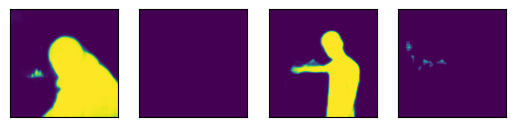

In [5]:
batch = torch.stack([transforms(d) for d in lst])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
normalized_masks = torch.nn.functional.softmax(output, dim=1)
masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(lst))
    for cls in ('person','cat')
]

show(masks)

shape = torch.Size([2, 640, 640]), dtype = torch.bool


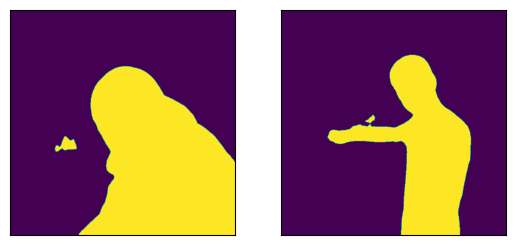

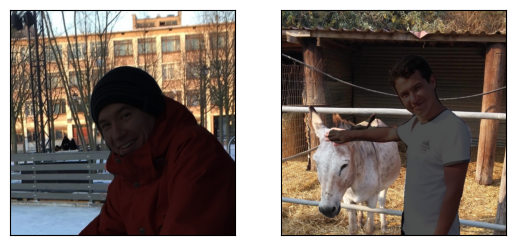

In [8]:
from torchvision.utils import draw_segmentation_masks
class_dim = 1
boolean_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['person'])
print(f"shape = {boolean_masks.shape}, dtype = {boolean_masks.dtype}")
show([m.float() for m in boolean_masks])

with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(lst, boolean_masks)
]
show(with_masks)

masks shape = torch.Size([21, 640, 640]), dtype = torch.float32
all_classes_masks = torch.Size([21, 640, 640]), dtype = torch.bool


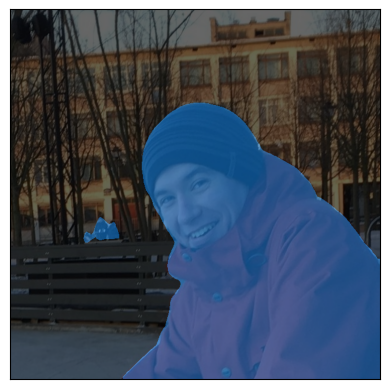

In [11]:
# Only first image
num_classes = normalized_masks.shape[1]
masks = normalized_masks[0]
class_dim = 0
all_classes_masks = masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"masks shape = {masks.shape}, dtype = {masks.dtype}")
print(f"all_classes_masks = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")

with_all_masks = draw_segmentation_masks(lst[0], masks=all_classes_masks, alpha=.6)
show(with_all_masks)

shape = torch.Size([21, 2, 640, 640]), dtype = torch.bool


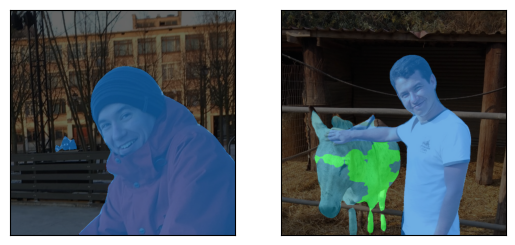

In [12]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(lst, all_classes_masks)
]
show(dogs_with_masks)